## Image Data generation

Now that we trained a model on real images, we will ask the following question : can we generate synthetic images to train our model ?

This part is thus focused on generation through DCGAN, as well as important metrics evaluating the distance between two set of data (e.g. between a set of real images and a set of synthetic ones)

**[Question 1]** Please give some reasons about potential advantages to train on synthetic data

**[Answer 1]**

I would say that it makes sense first of all for security reasons. If I generate synthetically a picture of a person, the system should not recognize him/her as the person I faked the image of.



In [3]:
%%capture
!pip install pytorch_lightning
### relaunch your environment

In [18]:
import argparse
import pytorch_lightning as pl
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
import torchmetrics
# import umap

from tqdm.notebook import tqdm

In [2]:
### moutning google drive
from google.colab import drive
drive.mount('/content/drive')

data_folder_path = '/content/drive/My Drive/Centrale'

import os

assert os.path.exists(data_folder_path), "The specified path does not exist."

ModuleNotFoundError: No module named 'google.colab'

In [19]:
def format_prepath(prepath: str) -> str:
    """
    Check if the prepath exists, and if it is a folder. Then retunrns the prepath with / at the end whatever the input is.
    """
    assert os.path.exists(prepath), "given prepath does'nt exist : " + prepath
    assert os.path.isdir(prepath), "given prepath is not a folder : " + prepath
    return prepath if prepath[-1] == '/' else prepath + '/'

def flatten_paths_recursively(root_path:str, output_absolute_path:bool=False, depth: "int|None" = None, exclusion_list:'list[str]' = [], keep_dir=False, parent_folder=None):
    """
    return the list of the paths of all the file contained in root_path
    INPUT:
    - root_path
    - output_absolute_path : if set to True, will store the absolute path
    - depth : if not None will stop the elts search at the given step
    - exclusion_list : will ignore the files whose name repsect the regexp stored
    - keep_dir : keep dir within returned list
    """
    result = []
    if os.path.isfile(root_path) or(not(depth is None) and depth == 0 ):
        if output_absolute_path:
            return [os.path.abspath(root_path)]
        return [os.path.relpath(root_path, parent_folder)]

    root_path = format_prepath(root_path)
    if parent_folder is None:
        print("getting all paths")
        iterator = tqdm(os.listdir(root_path))
        parent_folder = root_path
    else:
        iterator = os.listdir(root_path)
    if keep_dir:
        result.append(root_path[:-1])
    for elt in iterator:
        elt_path = root_path + elt
        result += flatten_paths_recursively(elt_path, output_absolute_path, None if depth is None else depth - 1, exclusion_list=exclusion_list, keep_dir=keep_dir, parent_folder=parent_folder)
    return result

## Data stuff

In [1]:
zip_file_path_in_drive = os.path.join(data_folder_path, 'img_align_celeba.zip')
!cp "{zip_file_path_in_drive}" .
!unzip -q img_align_celeba.zip

In [20]:
class CelebaSet:
    def __init__(self,imgs_path, transform):
        self.imgs_path = imgs_path
        self.transform = transform

    def __getitem__(self, i):
        image = Image.open(self.imgs_path[i])
        return self.transform(image)
    def __len__(self):
        return len(self.imgs_path)

In [21]:
class CelebaModule(pl.LightningDataModule):
    def __init__(self, imgs_root, num_workers = 10, batch_size=128, image_size =64):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.image_size = image_size

        self.imgs_root = imgs_root
        content = os.listdir(imgs_root)
        # What is going on here ???
        if os.path.isdir(content[0]):
            imgs = flatten_paths_recursively
        else:
            imgs = os.listdir(imgs_root)
        self.imgs = [os.path.join(imgs_root, img) for img in imgs]

        self.transform=transforms.Compose([
                               transforms.Resize((self.image_size, self.image_size)),
                               # transforms.CenterCrop(self.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    def setup(self, stage=None):
        # Split the data into train, val and test sets
        train_len = int(len(self.imgs) * 0.8)
        val_len = len(self.imgs) - train_len
        train_set, val_set = torch.utils.data.random_split(self.imgs, [train_len, val_len])
        self.train_set = CelebaSet(train_set, self.transform)
        self.val_set = CelebaSet(val_set, self.transform)

    def train_dataloader(self):
        # Return the train dataloader
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers )

    def val_dataloader(self):
        # Return the val dataloader
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)




In [22]:
from pytorch_lightning.loggers import CSVLogger

# Root directory for dataset
dataroot = "img_align_celeba"

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
batch_size = 64
image_size = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
workers=11

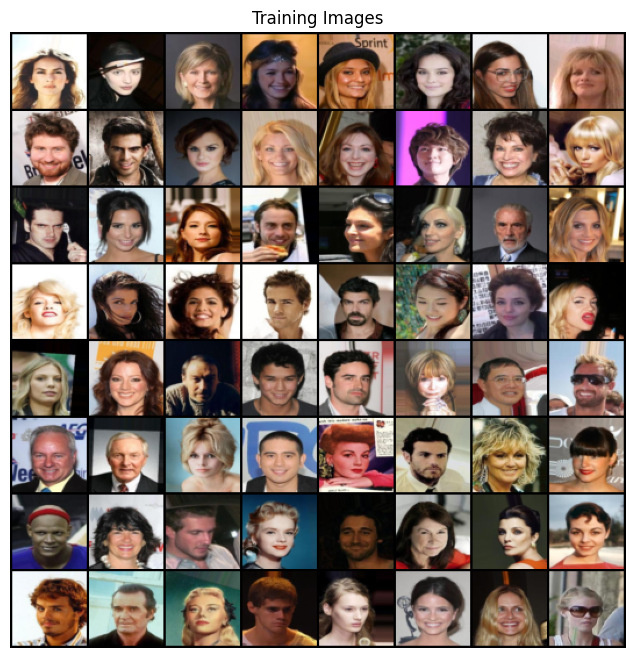

In [23]:
# We can use an image folder dataset the way we have it setup.
from my_dataset import CelebaModule, CelebaSet
# Create the dataset
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size, image_size = image_size, num_workers=workers)
data_module.setup()
# Create the dataloader
dataloader = data_module.train_dataloader()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "mps")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model stuff

In [24]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
class BasicGeneratorBlock(nn.Module):
    """ BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=1, padding=0, shortcut=None, anchor = False):
        super(BasicGeneratorBlock, self).__init__()
        # shortcut is a residual layer, if not provided, it doesn't use residual
        if shortcut is not None:
            self.shortcut_layer = shortcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.ConvTranspose2d( nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.ReLU(True))

    def forward(self, x):

        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)
        return shortcut + res



In [26]:

class Generator(nn.Module):
    # ngf == Number of generator filters, nz = size of the latent Z vector, nc = number of output channels
    def __init__(self, ngf, nz, nc, depth = 4):
        super(Generator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [BasicGeneratorBlock(nz, ngf *  2**(depth - 1), kernel_size, 1, 0)]
        for i in range(depth - 1, 0, -1):
            if (depth - i) % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicGeneratorBlock(ngf *  2**(i), ngf *  2**(i-1), kernel_size, 2, 1))

        layers.append(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)


    def forward(self, input):
        return self.main(input)

In [27]:
class BasicDiscriminatorBlock(nn.Module):
    """
    BasicBlock for DCGAn
    """
    def __init__(self, nb_features_in, nn_features_out, kernel_size, stride=2, padding=0, shortcut=None, anchor = False):
        super(BasicDiscriminatorBlock, self).__init__()
        if shortcut is not None:
            self.shortcut_layer = shortcut
        else:
            self.shortcut_layer = lambda x, res: torch.zeros_like(res, device=x.device)
        self.res_layer = nn.Sequential(
            nn.Conv2d(nb_features_in, nn_features_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(nn_features_out),
            nn.LeakyReLU(0.2, inplace=True))


    def forward(self, x):
        res = self.res_layer(x)
        shortcut = self.shortcut_layer(x, res)

        return shortcut + res


In [28]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, depth = 4):
        super(Discriminator, self).__init__()
        kernel_size = depth // 4 * 4
        layers = [nn.Conv2d(nc, ndf, kernel_size, 2, 1, bias=False),nn.LeakyReLU(0.2, inplace=True)]

        for i in range(0, depth - 1):
            if i % 4 == 0:
                kernel_size = max(4, kernel_size // 2)
            layers.append(BasicDiscriminatorBlock(ndf *  2**(i), ndf *  2**(i+1), kernel_size, 2, 1))

        layers.append(nn.Conv2d(ndf * 2**(depth - 1), 1, 4, 1, 0, bias=False))
        layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*layers)

    def forward(self, input):
        return self.main(input).squeeze()

**[Question 2]** Please complete the code below.

In [29]:
import gc
class DCGANTrain(pl.LightningModule):
    # nc = Number of output channel -> 3 (R, G, B), ngf = Number of Generator Filters, nz = size of latent space vector Z, ndf = Number of Discriminator Filters
    def __init__(self, learning_rate=0.0002, beta1 =0.5,  nc=3, ngf=64, nz=100, ndf=64, depth=4, generator_inner_repetition=1,device = "cuda" if torch.cuda.is_available() else "mps", images_folder = "images_logs"):
        super().__init__()
        self.generator_inner_repetition = generator_inner_repetition
        self.nz = nz
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.netG = Generator(ngf, nz, nc, depth).to(self.device)
        self.netG.apply(weights_init)
        self.netD = Discriminator(ndf, nc, depth).to(self.device)
        self.netD.apply(weights_init)
        self.learning_rate = learning_rate

        # self.criterion = # TO BE COMPLETED
        self.criterion = nn.BCELoss()

        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        os.makedirs(images_folder, exist_ok=True)
        self.image_logs = os.path.join(images_folder, f"training_{len(os.listdir(images_folder)) + 1}" )
        os.makedirs(self.image_logs)

    def forward(self, nb_images= 1, convert_to_image = False ):
        with torch.no_grad():
            tensors = self.netG(torch.randn(nb_images, self.nz, 1, 1, device=self.device))
            return_images = []
            for tensor in tensors:
                correct_range_tensor = (tensor - tensor.min())/ (tensor.max() - tensor.min()).detach().cpu()
                if convert_to_image:
                    correct_range_tensor = transforms.ToPILImage()(correct_range_tensor)
                return_images.append(correct_range_tensor)
            return return_images

    def training_step(self, real_images):
        ## Otpimize Discriminator

        accuracy_fake = 0
        z = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        self.netD.zero_grad()
        self.netG.zero_grad()

        # COMPUTE DISCRIMINATOR LOSS ON FAKE SAMPLES
        # LossFake = ## TO BE COMPLETED
        fake_images = self.netG(z)
        fake_pred = self.netD(fake_images.detach())
        LossFake = self.criterion(fake_pred, torch.zeros_like(fake_pred, device=self.device))
        LossFake.backward()

        # COMPUTE DISCRIMINATOR LOSS ON REAL SAMPLES
        # LossReal = # TO BE COMPLETED
        real_pred = self.netD(real_images)
        LossReal = self.criterion(real_pred, torch.ones_like(real_pred, device=self.device))
        LossReal.backward()
        self.optimizerD.step()


        DLoss = LossReal.item() + LossFake.item()

        self.log('train_discriminator_loss', DLoss, on_step=True, on_epoch=True, logger=True)
        ## Optimize generator

        z2 = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        self.netD.zero_grad()
        self.netG.zero_grad()



        # GLoss = # TO BE COMPLETED
        fake_images_2 = self.netG(z2)
        fake_pred_2 = self.netD(fake_images_2)
        GLoss = self.criterion(fake_pred_2, torch.ones_like(fake_pred_2, device=self.device))

        GLoss.backward()
        self.optimizerG.step()
        self.log("generator acc", accuracy_fake, on_step=True, on_epoch=True, logger=True)
        self.log('train_generator_loss', GLoss, on_step=True, on_epoch=True, logger=True)


    def validation_step(self, real_images):
        z = torch.randn(len(real_images), self.nz, 1, 1, device=self.device)
        fake_images = self.netG(z).detach()

        real_labels = torch.ones(len(real_images), device= self.device)
        fake_labels = torch.zeros(len(real_images), device= self.device)
        labels = torch.cat((real_labels, fake_labels), dim = 0 )
        images = torch.cat((real_images, fake_images), dim = 0)
        netDpreds = self.netD(images)
        fake_preds = netDpreds[-len(real_images):]
        real_preds = netDpreds[:len(real_images)]
        accuracy_fake = self.accuracy(fake_preds, fake_labels)
        accuracy_real = self.accuracy(real_preds, real_labels)

        self.log("val_accuracy_fake_images", accuracy_fake, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy_real_images", accuracy_real, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        epoch_images = os.path.join(self.image_logs, f"{self.current_epoch}.png")
        if not(os.path.exists(epoch_images)):
            sample_imgs = fake_images
            grid = torchvision.utils.make_grid(sample_imgs, normalize=True)
            torchvision.utils.save_image(grid, epoch_images, normalize=True)


    def on_validation_end(self) -> None:
        gc.collect()
    def configure_optimizers(self):
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))

In [30]:
def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
trainModule = DCGANTrain()


In [31]:
trainer = pl.Trainer(max_epochs=2,logger=[CSVLogger(save_dir="metrics" , name="result")], accelerator="mps")
trainer.fit(trainModule, data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ netG      │ Generator          │  3.6 M │ train │     0 │
│ 1 │ netD      │ Discriminator      │  2.8 M │ train │     0 │
│ 2 │ criterion │ BCELoss            │      0 │ train │     0 │
│ 3 │ accuracy  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 6.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/Users/alfio/python_venv/general/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.p
y:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker 
initialization.

/Users/alfio/python_venv/general/lib/python3.13/site-packages/pytorch_lightning/loops/optimization/automatic.py:134
: `training_step` returned `None`. If this was on purpose, ignore this warning...

`Trainer.fit` stopped: `max_epochs=2` reached.


**[Question 3]**: Visualize the results and comment on their quality. What do think might be done to increase the quality? Try to do so and try to change the parameters. Do some annoying phenomena occur, why do you think so?

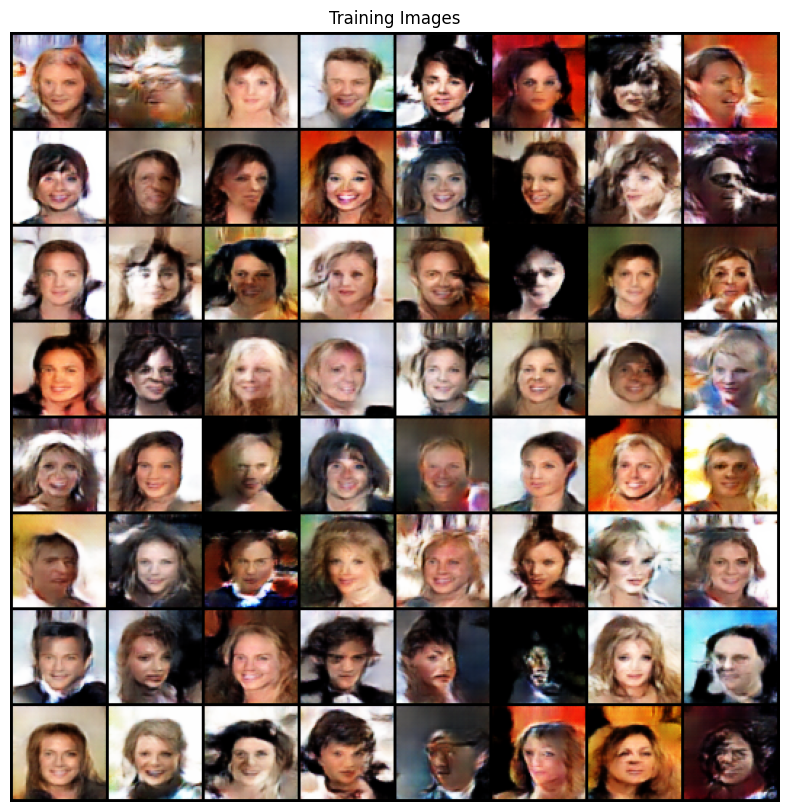

In [53]:
img = trainModule(64)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(img[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Distance Metrics

Now that we can generate images, we will study the distances between the real dataset and the generate images of our model, and compare it with a set of images coming from a very well known diffusion model : DDPM (c.f. https://arxiv.org/pdf/2006.11239).

Specific metrics such as the Frechet Distance and the Kernel Distance exists to characterize how much two sets of images are far from each other. We will study them using the latent space of a resnet 18 trained on Image Net. But usually, we use the features from an Inception v3 with the associated metrics FID (for frechet inception distance) and KID (for Kernel Inception Distance).


In [ ]:
! cp -r /content/drive/MyDrive/Centrale/ddpm ./ && cd ddpm && tar -xf generated.tar

In [54]:
## Generate lany images
nb_images_to_pick = 10000

In [5]:
##  Use the resnet 18 implementation of torchvision to extract the features
import torch
import torch.nn as nn
from torchvision import models as t_models
FIDweights = t_models.ResNet18_Weights.IMAGENET1K_V1
FID_image_transforms = FIDweights.transforms()

resnet18Classifier = t_models.resnet18(pretrained=FIDweights)
# Keep everything except the final classificaton layer to turn this model into a feature extractor.
FIDFeatsExtractor = nn.Sequential(*list(resnet18Classifier.children())[:-1])
FIDFeatsExtractor = FIDFeatsExtractor.eval().cuda()

In [59]:
nb_images_to_pick = 10000
data_module = CelebaModule(imgs_root=dataroot,batch_size= batch_size , image_size = image_size, num_workers=workers)
data_module.setup()
rnd_idx = random.sample(list(np.arange(len(data_module.train_set))), nb_images_to_pick)
# real_images = [data_module.train_set[i] for i in rnd_idx]
celeba_feats = []
with torch.no_grad():
    for i in tqdm(rnd_idx):
        image = data_module.train_set[i]
        image_feats = FIDFeatsExtractor(FID_image_transforms(image).unsqueeze(0).cuda())
        celeba_feats.append(image_feats.cpu())
    celeba_feats = torch.cat(celeba_feats, dim=0)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [61]:
data_folder_path = "Centrale"
state_dict = torch.load(os.path.join(data_folder_path, "celeba_checkpoint/epoch=49-step=126650.ckpt"), map_location=torch.device('cpu'))["state_dict"]
trainModule.load_state_dict(state_dict)
_ = trainModule.eval()
fake_images = trainModule(nb_images_to_pick)
fake_images_feats = []
with torch.no_grad():
    for image in tqdm(fake_images):
        image_feats = FIDFeatsExtractor(FID_image_transforms(image).unsqueeze(0).cuda())
        fake_images_feats.append(image_feats.cpu())
    fake_images_feats = torch.cat(fake_images_feats, dim=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
class DDPMImageDataset(torch.utils.data.Dataset):
    # to complete
    def __init__(self, images_dir_path, transform=None):
        self.image_paths = [os.path.join(images_dir_path, image) for image in os.listdir(images_dir_path)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB") # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image

# Create a dataset and dataloader for the DDPM images
ddpm_dataset = DDPMImageDataset("ddpm/generated", transform=FID_image_transforms)
ddpm_dataloader = torch.utils.data.DataLoader(ddpm_dataset, batch_size=batch_size, num_workers=workers)

# Extract features
ddpm_features = []
with torch.no_grad():
    for images in tqdm(ddpm_dataloader, desc="Extracting DDPM features"):
        images = images.cuda()
        features = FIDFeatsExtractor(images).squeeze() # Squeeze the spatial dimensions
        ddpm_features.append(features.cpu())

ddpm_features = torch.cat(ddpm_features, dim=0)

Extracting DDPM features:   0%|          | 0/157 [00:00<?, ?it/s]

In [65]:
celeba_feats = np.asarray(celeba_feats.squeeze())
fake_images_feats = np.asarray(fake_images_feats.squeeze())
ddpm_features = np.asarray(ddpm_features.squeeze())

### FD

**[Question 4]** - Write here the formula of the FD (frechet distance) between two distributions.

**[Answer 4]** Source: https://www.youtube.com/watch?v=MJt_ahtO-to , min 51:56
$$FID = \|\mu_{\mathcal{T}} - \mu_{\mathcal{G}}\|^2 + \text{Tr}(\Sigma_{\mathcal{T}} + \Sigma_{\mathcal{G}} - 2(\Sigma_{\mathcal{T}}\Sigma_{\mathcal{G}})^{1/2})$$

Given $F_{\mathcal{G}}$ and $F_{\mathcal{T}}$, the feature representations for the generated samples and the test sample respectively, $(\mu_{\mathcal{G}}, \Sigma_{\mathcal{G}})$ and $(\mu_{\mathcal{T}}, \Sigma_{\mathcal{T}})$ denote the mean and covariances of the two multivariate Gaussian fit on $F_{\mathcal{G}}$ and $F_{\mathcal{T}}$.

**[Question 5]** - Evaluate the theoritical number of samples n required to compute the estimate S of the covariance matrixof gaussian samples of size 512 generated with a covariance matrix Σ, such that the distance expectation under the froebenius norm between S and \Sigma is below ϵ i.e. : $$E(|| S - \Sigma||_F )\leq \epsilon$$.

You can use $$Var(S_{jk}) = \frac{1}{n} \big( \Sigma_{jj}\Sigma_{kk} + \Sigma_{jk}^2 \big).$$ to simplify the computations!

Answer Here

**[Answer 5]**
The frobenius distance for a matrix A is equal to $$\| A \|_F = \sqrt{\sum_{i,j} a_{i,j}^2}$$

So in our case: $$E(\| S - \Sigma \|_F) = E\left(\sqrt{\sum_{j=1}^{d} \sum_{k=1}^{d} (S_{jk} - \Sigma_{jk})^2}\right)$$

The square root function is a concave function, so we can apply the Jensen's inequality: $$E[\sqrt{X}] \leq \sqrt{E[X]}$$

Hence we have: $$E\left(\sqrt{\sum_{j=1}^{d} \sum_{k=1}^{d} (S_{jk} - \Sigma_{jk})^2}\right) \leq \sqrt{E\left[\sum_{j=1}^{d} \sum_{k=1}^{d} (S_{jk} - \Sigma_{jk})^2\right]}$$

So we can now solve for: $$\sqrt{E\left[\sum_{j=1}^{d} \sum_{k=1}^{d} (S_{jk} - \Sigma_{jk})^2\right]} \leq \epsilon$$ which is actually an upper bound for the original question.

By linearity of expectation, we move the expectation inside the summation:
$$ \sqrt{\sum_{j=1}^{d} \sum_{k=1}^{d} E[(S_{jk} - \Sigma_{jk})^2]} \leq \epsilon $$

Since $E[S_{jk}] = \Sigma_{jk}$, the term inside the summation is $\text{Var}(S_{jk})$. Substituting the given identity:
$$ \sqrt{\sum_{j=1}^{d} \sum_{k=1}^{d} \frac{1}{n}\big( \Sigma_{jj}\Sigma_{kk} + \Sigma_{jk}^2 \big) } \leq \epsilon $$

Squaring both sides (we can do it as both sides are $\geq 0$) and solving for $n$ yields:
$$ \frac{1}{n} \sum_{j=1}^{d} \sum_{k=1}^{d} (\Sigma_{jj}\Sigma_{kk} + \Sigma_{jk}^2) \leq \epsilon^2 $$

Also given: $$\sum_{j=1}^{d} \sum_{k=1}^{d} \Sigma_{jj}\Sigma_{kk} = \left( \sum_{j=1}^{d} \Sigma_{jj} \right) \left( \sum_{k=1}^{d} \Sigma_{kk} \right) = \text{Tr}(\Sigma)^2$$
and $$\sum_{j=1}^{d} \sum_{k=1}^{d} \Sigma_{jk}^2 = \|\Sigma\|_F^2$$
we can rewrite the solution as: $$n \geq \frac{\text{Tr}(\Sigma)^2 + \|\Sigma\|_F^2}{\epsilon^2}$$


**[Question 6]** Evaluate n for $\Sigma  = I$, and epsilon equal to 10. Comment.

Answer Here

**[Answer 7]**
For an identity matrix of size $d = 512$:
$$\text{Tr}(I) = \sum_{i=1}^{512} 1 = 512$$
$$\|I\|_F^2 = \sum_{i=1}^{512} 1^2 = 512$$

Substituting these into the inequality:
$$n \geq \frac{512^2 + 512}{10^2}$$
$$n \geq \frac{262144 + 512}{100}$$
$$n \geq \frac{262656}{100}$$
$$n \geq 2626.56$$

The minimum number of samples required is:
$$n = 2627$$

**[Question 7]** Using the features of the resnet 18 trained on imageNet compute the FD between Celeba HQ,DDPM, and between CelebaHQ and the images you generated. You can compare the results you obtain with the torchmetrics library implementation output. Comments the results.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import sqrtm  # For the matrix square root
from torch.utils.data import DataLoader, TensorDataset
import warnings
class CustomFID:
    def __init__(self,device):
        self.device = device

    def _calculate_stats(self, features):
        """
        Calculates the mean and covariance matrix for a set of features.

        Args:
            features (np.ndarray): (N_samples, N_features)

        Returns:
            tuple: (mu, sigma)
                mu (np.ndarray): (N_features,)
                sigma (np.ndarray): (N_features, N_features)
        """
        mu, sigma = None, None
        # CODE HERE
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma

    def _calculate_frechet_distance(self, mu1, sigma1, mu2, sigma2, eps=1e-6):
        """
        Applies the FD formula.

        eps is added to the diagonal of covariances for numerical stability
        (though often not strictly necessary if using the complex-number check).
        """

        ## CODE HERE
        mu_diff = mu1 - mu2
        first_term = mu_diff.dot(mu_diff)
        offset = np.eye(sigma1.shape[0]) * eps
        cov_mean = sqrtm((sigma1 + offset).dot(sigma2 + offset))
        second_term = np.trace(sigma1 + sigma2 - 2.0 * cov_mean)

        return first_term + second_term

    def compute(self, features_real, features_fake):
        """
        Computes the FID score between two datasets.

        Args:
            real_dataloader (DataLoader): DataLoader for the real images.
            fake_dataloader (DataLoader): DataLoader for the fake/generated images.

        Returns:
            float: The calculated FID score.
        """

        if features_real.shape[0] < 2 or features_fake.shape[0] < 2:
            warnings.warn("Must have at least 2 samples to calculate covariance. "
                          "Returning FID=inf.")
            return np.inf

        print("Calculating stats for real images...")
        mu_real, sigma_real = self._calculate_stats(features_real)

        print("Calculating stats for fake images...")
        mu_fake, sigma_fake = self._calculate_stats(features_fake)

        print("Calculating Frechet distance...")
        fid_score = self._calculate_frechet_distance(mu_real, sigma_real,
                                                   mu_fake, sigma_fake)

        return fid_score

In [8]:
from torchmetrics.image.fid import FrechetInceptionDistance

custom_fid = CustomFID(FIDFeatsExtractor)
custom_fid_celeba = custom_fid.compute(celeba_feats, fake_images_feats)
fid = FrechetInceptionDistance()
fid.update(celeba_feats, real=True)

fid_temp = fid.clone()
fid.update(fake_images_feats, real=False)
print(f"Custom FID between CelebaHQ and generated images: {custom_fid_celeba}")
print(f"Torchvision FID between CelebaHQ and generated images: {fid_temp.compute()}")
custom_fid_ddpm = custom_fid.compute(celeba_feats, ddpm_features)
fid = FrechetInceptionDistance()
fid.update(celeba_feats, real=True)

fid_temp = fid.clone()
fid_temp.update(ddpm_features, real=False)
print(f"FID between CelebaHQ and DDPM images: {custom_fid_ddpm}")
print(f"Torchvision FID between CelebaHQ and DDPM images: {fid_temp.compute()}")


Calculating stats for real images...
Calculating stats for fake images...
Calculating Frechet distance...


ValueError: Expecting image as torch.Tensor with dtype=torch.uint8

**[Answer 7]**


**[Question 8]** Look at the formal definition of the KID and rewrite it here. What is the advantage of the KID over the FID ? Can you find drawbacks associated to the use of the KID over the FID too ?

Answer Here

**[Answer 8]** ref: (https://arxiv.org/pdf/1801.01401), (https://www.youtube.com/watch?v=MJt_ahtO-to min: 54:41), (https://lightning.ai/docs/torchmetrics/stable/image/kernel_inception_distance.html)

The Kernel Inception Distance is equal to the squared MMD(Maximum Mean Discrepancy) between the feature representations of the images
$$KID(p, q) = MMD^2(p, q) = \mathbb{E}_{\mathbf{x}, \mathbf{x}' \sim p} [K(f(\mathbf{x}), f(\mathbf{x}'))] + \mathbb{E}_{\mathbf{y}, \mathbf{y}' \sim q} [K(f(\mathbf{y}), f(\mathbf{y}'))] - 2\mathbb{E}_{\mathbf{x} \sim p, \mathbf{y} \sim q} [K(f(\mathbf{x}), f(\mathbf{y}))]$$

where
- $f$ is the feature extraction function.
- $K$ is a polynomial kernel function that controls the distance between two features: $k(x, y) = (\gamma * x^Ty + coef)^{degree}$.
- $p$ and $q$ are respectively the real and the generated images distributions.
- $\mathbb{E}_{\mathbf{x}, \mathbf{x}' \sim p} [K(f(\mathbf{x}), f(\mathbf{x}'))]$ measures how diverse the real data is within the feature space.
- $\mathbb{E}_{\mathbf{y}, \mathbf{y}' \sim q} [K(f(\mathbf{y}), f(\mathbf{y}'))]$ measures the diversity of the generated images, again within the feature space.
- $\mathbb{E}_{\mathbf{x} \sim p, \mathbf{y} \sim q} [K(f(\mathbf{x}), f(\mathbf{y}))]$ measures how much the generated images differ from the real images (again within the feature space).

Practically, KID avoids comparing an image to itself, this leads to an unbiased version of KID which has the following formula.
$$KID_u = MMD^2_u(p, q) = \frac{1}{n(n-1)} \sum_{i \neq j}^n K(f(\mathbf{x}_i), f(\mathbf{x}_j)) + \frac{1}{m(m-1)} \sum_{i \neq j}^m K(f(\mathbf{y}_i), f(\mathbf{y}_j)) - \frac{2}{nm} \sum_{i=1}^n \sum_{j=1}^m K(f(\mathbf{x}_i), f(\mathbf{y}_j))$$

The main advantage of using KID over FID is the fact that the first is unbiased, while FID measures the distance between two distributions by using their means and covariances, but these are sample means and covariances
rather than the true population estimates. This means that to be used there needs to be a high number of samples, so that the estimates are more aligned with the population true estimates. And we've seen that, above when
we've calculated the minimum number of samples $n$ required for S and $\Sigma$ to be close to each other.

Another advantage might be the fact that for FID we assume the feature extracted to follow a multivariate gaussian distribution, while for KID we just use a kernel function that may not assume anything about how data is distributed.

The issue of KID is in the computational efficiency. FID is linear, $O(N)$, as we just need to compute the mean and covariance of the feature vectors.
KID is quadratic, $O(N^2)$ as even if the images are sampled we still need to compute for each pair of sampled images the kernel results.

**[Question 9, optional]**
Similarly, implement the KID, you can compare the results you have with the torchmetrics implementation.

In [ ]:
### Write code part